# VISUALIZATION OF EVENTS IN HGCAL 

In [1]:
import ROOT
import pandas as pd
import numpy as np 

import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
mpl.rcParams['image.cmap'] = 'hot_r'

Welcome to JupyROOT 6.14/04


In [ ]:
'''
#TBranches containing the 3D TCs' info
branches_tc = ['event', 'tc_id', 'tc_subdet', 'tc_zside', 'tc_layer', 'tc_waferu', 'tc_waferv', 'tc_wafertype', 'tc_panel_number', 'tc_panel_sector', 'tc_cellu', 'tc_cellv', 'tc_data', 'tc_uncompressedCharge', 'tc_compressedCharge',  'tc_pt', 'tc_energy', 'tc_eta', 'tc_phi', 'tc_x', 'tc_y', 'tc_z', 'tc_mipPt', 'tc_cluster_id', 'tc_multicluster_id', 'tc_multicluster_pt']
branches_tc_flatten = ['tc_id', 'tc_subdet', 'tc_zside', 'tc_layer', 'tc_waferu', 'tc_waferv', 'tc_wafertype', 'tc_panel_number', 'tc_panel_sector', 'tc_cellu', 'tc_cellv', 'tc_data', 'tc_uncompressedCharge', 'tc_compressedCharge',  'tc_pt', 'tc_energy', 'tc_eta', 'tc_phi', 'tc_x', 'tc_y', 'tc_z', 'tc_mipPt', 'tc_cluster_id', 'tc_multicluster_id', 'tc_multicluster_pt']

#TBranches containing the 3D clusters' info
branches_cl3d = ['event', 'cl3_id', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 'cl3d_clusters_n', 'cl3d_showerlength', 'cl3d_coreshowerlength',  'cl3d_firstlayer','cl3d_maxlayer','cl3d_seetot', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',  'cled_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',  'cl3d_ntc67', 'cl3d_ntc90', 'cl3d_bdteg', 'cl3d_uality']
branches_cl3d_flatten = ['cl3_id', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 'cl3d_clusters_n', 'cl3d_showerlength', 'cl3d_coreshowerlength',  'cl3d_firstlayer','cl3d_maxlayer','cl3d_seetot', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',  'cled_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',  'cl3d_ntc67', 'cl3d_ntc90', 'cl3d_bdteg', 'cl3d_uality']

# TBranches containing the gen taus' info
branches_gentau = ['event', 'gentau_pt', 'gentau_eta', 'gentau_phi', 'gentau_energy', 'gentau_mass', 'gentau_vis_pt', 'gentau_vis_eta', 'gentau_vis_phi', 'gentau_vis_energy', 'gentau_vis_mass', 'gentau_decayMode']
branches_gentau_flatten = ['gentau_pt', 'gentau_eta', 'gentau_phi', 'gentau_energy', 'gentau_mass', 'gentau_vis_pt', 'gentau_vis_eta', 'gentau_vis_phi', 'gentau_vis_energy', 'gentau_vis_mass', 'gentau_decayMode']

# TBranches containing the gen jets' info
branches_genjet = ['event', 'genjet_pt', 'genjet_eta', 'genjet_phi', 'genjet_energy', 'genjet_mass']
branches_genjet_flatten = ['genjet_pt', 'genjet_eta', 'genjet_phi', 'genjet_energy', 'genjet_mass']
'''

In [2]:
indir = '/data_cms_upgrade/motta/HGCAL_SKIMS/SKIM_21Apr2021'
rfile = ROOT.TFile.Open(indir+'/SKIM_RelValTenTau_noPU_caloTruth/mergedOutput.root')
tree = rfile.Get('HGCALskimmedTree')

TAU = True
QCD = False

print(tree.GetEntries())

8471


In [ ]:
print('LIST OF ENTRIES WITH ONE TAU PER ENDCAP')
for evt in range(tree.GetEntries()):
    tree.GetEntry(evt)
    l = len(tree.gentau_decayMode)
    if l <= 2 and l > 0: 
        if l == 2:
            gen_eta = tree.gentau_vis_eta
            if gen_eta[0]*gen_eta[1] < 0:
                print(evt, end = ', ')
        else:
            print(evt, end = ', ')

In [ ]:
print(r'LIST OF ENTRIES WITH ONE TAU PER ENDCAP AND PI0 IN THE DECAY')
for evt in range(tree.GetEntries()):
    tree.GetEntry(evt)
    l = len(tree.gentau_decayMode)
    if l <= 2and l > 0: 
        if l == 2:
            gen_eta = tree.gentau_vis_eta
            gen_dm = tree.gentau_decayMode
            if (gen_eta[0]*gen_eta[1]) < 0 and (gen_dm[0] == 1 or gen_dm[0] == 11) or (gen_dm[1] == 1 or gen_dm[1] == 11 < 0):
                print(evt, end = ', ')
        else:
            gen_dm = tree.gentau_decayMode
            if gen_dm[0] == 1 or gen_dm[0] == 11:
                print(evt, end = ', ')

In [3]:
# declaration of C++ functions to do the selection of which endcup to choose (+1/-1)

ROOT.gInterpreter.Declare('''
// these three functions do also the matching between cl3d_id and tc_multicluster_id

vector<float> sideChoice (vector<int> zside, vector<float> tochoose, vector<int> tcID, vector<unsigned int> clID, int side){
    vector<float> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        
        for (int j=0; j<clID.size();j++){
            if (tcID[i] != clID[j]) continue;
            
            tosave.push_back(tochoose[i]);
        }
    }
    
    return tosave;
}

vector<int> sideChoice (vector<int> zside, vector<int> tochoose, vector<int> tcID, vector<unsigned int> clID, int side){
    vector<int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        for (int j=0; j<clID.size();j++){
            if (tcID[i] != clID[j]) continue;
            
            tosave.push_back(tochoose[i]);
        }
    }
    
    return tosave;
}

vector<unsigned int> sideChoice (vector<int> zside, vector<unsigned int> tochoose, vector<int> tcID, vector<unsigned int> clID, int side){
    vector<unsigned int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        for (int j=0; j<clID.size();j++){
            if (tcID[i] != clID[j]) continue;
            
            tosave.push_back(tochoose[i]);
        }
    }
    
    return tosave;
}

// --------------------------------------------------------------------------------------------------------------------------------------------------------
// --------------------------------------------------------------------------------------------------------------------------------------------------------

// these three functions do not do the matching between cl3d_id and tc_multicluster_id and taking genparticle_index as input

vector<float> sideChoice (vector<int> zside, vector<float> tochoose, vector<int> tcID, int side){
    vector<float> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
            
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

vector<int> sideChoice (vector<int> zside, vector<int> tochoose, vector<int> tcID, int side){
    vector<int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

vector<unsigned int> sideChoice (vector<int> zside, vector<unsigned int> tochoose, vector<int> tcID, int side){
    vector<unsigned int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

// --------------------------------------------------------------------------------------------------------------------------------------------------------
// --------------------------------------------------------------------------------------------------------------------------------------------------------

// these three functions do not do the matching between cl3d_id and tc_multicluster_id and taking tc_multicluster_id as input as input

vector<float> sideChoice (vector<int> zside, vector<float> tochoose, vector<unsigned int> tcID, int side){
    vector<float> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
            
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

vector<int> sideChoice (vector<int> zside, vector<int> tochoose, vector<unsigned int> tcID, int side){
    vector<int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

vector<unsigned int> sideChoice (vector<int> zside, vector<unsigned int> tochoose, vector<unsigned int> tcID, int side){
    vector<unsigned int> tosave;

    for (int i=0; i<zside.size(); i++){
        if (zside[i] * side < 0) continue;
        
        tosave.push_back(tochoose[i]);
    }
    
    return tosave;
}

// --------------------------------------------------------------------------------------------------------------------------------------------------------
// --------------------------------------------------------------------------------------------------------------------------------------------------------

vector<float> vectorRatio(vector<float> num, vector<float> denom){
    vector<float> tosave;
    
    if (num.size() != denom.size()){ exit(-1);}
    
    for (int i=0; i<num.size(); i++){
        tosave.push_back(num[i]/denom[i]);
    }
    
    return tosave;
}

''')

True

In [53]:
entry = 17 # this is the entry number [0,nEntries] NOT the event number
tree.GetEntry(entry)

262606

In [ ]:
tree.Show(entry)

In [54]:
if TAU:
    gen_dm = tree.gentau_decayMode 
    print('FOUND',len(gen_dm),'TAUS IN THIS EVENT')
    gen_pt = tree.gentau_vis_pt
    gen_eta = tree.gentau_vis_eta
    gen_phi = tree.gentau_vis_phi
    gen_mass = tree.gentau_vis_mass
elif QCD:
    gen_dm = -2*np.sgn(tree.genjet_pt)
    gen_pt = tree.genjet_pt
    gen_eta = tree.genjet_eta
    gen_phi = tree.genjet_phi
    gen_mass = tree.genjet_mass

gen_dict = {}

for i in range(len(gen_pt)):
    gen_dict[i] = {'DM': {}, 'v4': {}}
    gen_dict[i]['DM'] = gen_dm[i]
    gen_dict[i]['v4'] = ROOT.TLorentzVector()
    gen_dict[i]['v4'].SetPtEtaPhiM(gen_pt[i],gen_eta[i],gen_phi[i],gen_mass[i])

FOUND 2 TAUS IN THIS EVENT


In [ ]:
'''
# MATCH TCs AND Cl3D ID

# choose the endcap we want to look at and store all the needed info for the display

event = tree.event 
side = 1
zside = tree.tc_zside
clID = tree.cl3d_id
tcID = tree.tc_genparticle_index

x         = ROOT.sideChoice(zside, tree.tc_x,               tcID, clID, side)
y         = ROOT.sideChoice(zside, tree.tc_y,               tcID, clID, side)
z         = ROOT.sideChoice(zside, tree.tc_z,               tcID, clID, side)
layer     = ROOT.sideChoice(zside, tree.tc_layer,           tcID, clID, side)
clusterID = ROOT.sideChoice(zside, tree.tc_genparticle_index, tcID, clID, side)
energy    = ROOT.sideChoice(zside, tree.tc_energy,          tcID, clID, side)
'''

In [57]:
# DO NOT MATCH TCs AND Cl3D ID - tc_genparticle_index as clusterID

# choose the endcap we want to look at and store all the needed info for the display

event = tree.event 
side = 1
zside = tree.tc_zside
tcID = tree.tc_genparticle_index

x         = ROOT.sideChoice(zside, tree.tc_x,               tcID, side)
y         = ROOT.sideChoice(zside, tree.tc_y,               tcID, side)
z         = ROOT.sideChoice(zside, tree.tc_z,               tcID, side)
layer     = ROOT.sideChoice(zside, tree.tc_layer,           tcID, side)
clusterID = ROOT.sideChoice(zside, tree.tc_genparticle_index, tcID, side)
energy    = ROOT.sideChoice(zside, tree.tc_energy,          tcID, side)

In [60]:
clusterID

<ROOT.vector<int> object at 0xde09570>

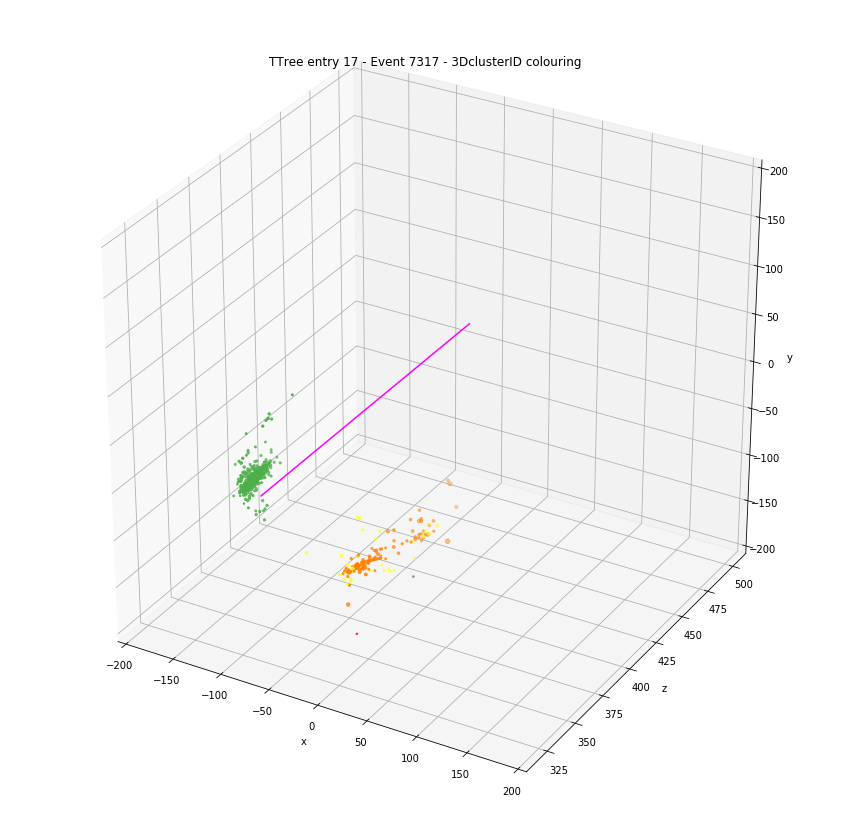

In [58]:
fig = plt.figure(figsize = (15, 15))
ax2 = fig.add_subplot(111, projection='3d')
cmap = 'Set1'

s = np.sqrt(energy)*10
c = clusterID

ax2.scatter(x, z, y, c = c, s = s, marker = 'o', cmap = cmap)
for i in gen_dict:
    gen_x = gen_dict[i]['v4'].Px()
    gen_y = gen_dict[i]['v4'].Py()
    gen_z = gen_dict[i]['v4'].Pz()
    gen_dm = gen_dict[i]['DM']
    gen_eta_sig = np.sign(gen_dict[i]['v4'].Eta())
    up_scale = 500/gen_z
    down_scale = 320/gen_z
    if gen_dm == 0: gen_c = 'limegreen'; lab =' 1-prong'
    elif gen_dm == 1: gen_c = 'blue'; lab =' 1-prong + \pi^0'
    elif gen_dm == 10: gen_c = 'orange'; lab =' 3-prong'
    elif gen_dm == 11: gen_c = 'fuchsia'; lab =' 3-prong + \pi^0'
    elif gen_dm == -2: gen_c = 'cyan'; lab =' QCD'
    if side*gen_eta_sig > 0:
        #r = 0.3 * 4 * tau_dict[i]['v4'].Pt()
        #zetas = np.linspace(tau_z*tau_eta_sig*down_scale,tau_z*tau_eta_sig*up_scale,1000)
        #ax2.plot(np.sin(zetas) * r,zetas,np.cos(zetas) * r, c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)

        ax2.plot([gen_x,gen_x],[gen_z*gen_eta_sig*down_scale,gen_z*gen_eta_sig*up_scale],[gen_y,gen_y], c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)

#plt.legend(loc = 'upper left', fontsize=15)
        
ax2.set_xlabel('x'); ax2.set_ylabel('z'); ax2.set_zlabel('y')
ax2.set_xlim(-200,200); ax2.set_zlim(-200,200)
ax2.set_title('TTree entry %i - Event %i - 3DclusterID colouring' % (entry, event))

fig.show()

In [50]:
# DO NOT MATCH TCs AND Cl3D ID - tc_multicluster_id as clusterID

# choose the endcap we want to look at and store all the needed info for the display

event = tree.event 
side = -1
zside = tree.tc_zside
tcID = tree.tc_multicluster_id

x         = ROOT.sideChoice(zside, tree.tc_x,               tcID, side)
y         = ROOT.sideChoice(zside, tree.tc_y,               tcID, side)
z         = ROOT.sideChoice(zside, tree.tc_z,               tcID, side)
layer     = ROOT.sideChoice(zside, tree.tc_layer,           tcID, side)
clusterID = ROOT.sideChoice(zside, tree.tc_multicluster_id, tcID, side)
energy    = ROOT.sideChoice(zside, tree.tc_energy,          tcID, side)

In [51]:
print(len(x))

99


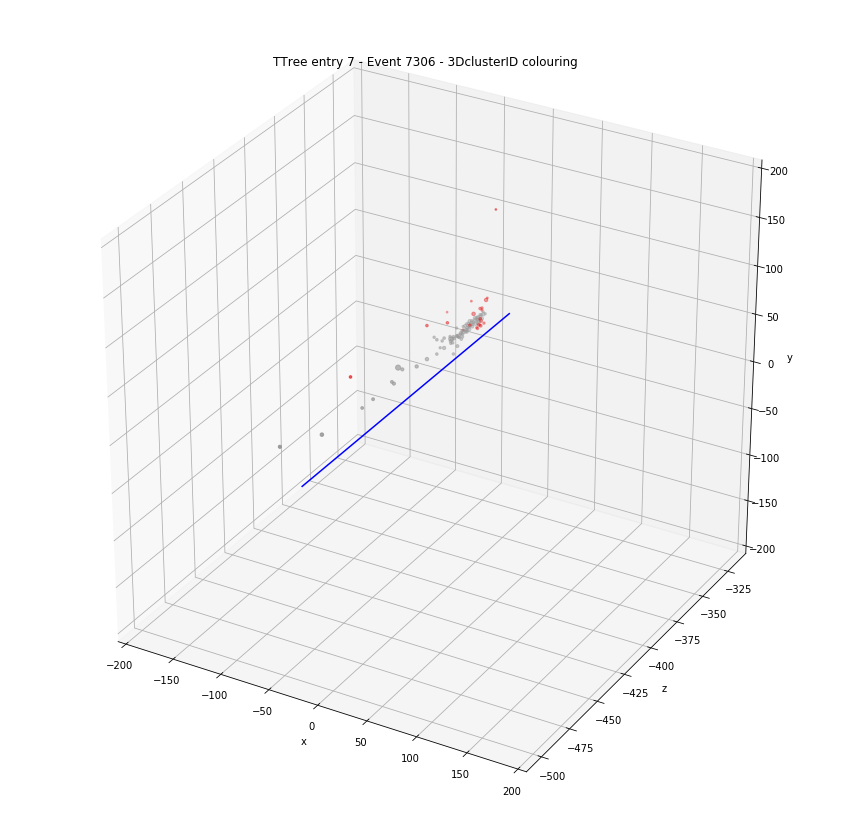

In [52]:
fig = plt.figure(figsize = (15, 15))
ax2 = fig.add_subplot(111, projection='3d')
cmap = 'Set1'

s = np.sqrt(energy)*10
c = clusterID

ax2.scatter(x, z, y, c = c, s = s, marker = 'o', cmap = cmap)
for i in gen_dict:
    gen_x = gen_dict[i]['v4'].Px()
    gen_y = gen_dict[i]['v4'].Py()
    gen_z = gen_dict[i]['v4'].Pz()
    gen_dm = gen_dict[i]['DM']
    gen_eta_sig = np.sign(gen_dict[i]['v4'].Eta())
    up_scale = 500/gen_z
    down_scale = 320/gen_z
    if gen_dm == 0: gen_c = 'limegreen'; lab =' 1-prong'
    elif gen_dm == 1: gen_c = 'blue'; lab =' 1-prong + \pi^0'
    elif gen_dm == 10: gen_c = 'orange'; lab =' 3-prong'
    elif gen_dm == 11: gen_c = 'fuchsia'; lab =' 3-prong + \pi^0'
    elif gen_dm == -2: gen_c = 'cyan'; lab =' QCD'
    if side*gen_eta_sig > 0:
        #r = 0.3 * 4 * tau_dict[i]['v4'].Pt()
        #zetas = np.linspace(tau_z*tau_eta_sig*down_scale,tau_z*tau_eta_sig*up_scale,1000)
        #ax2.plot(np.sin(zetas) * r,zetas,np.cos(zetas) * r, c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)

        ax2.plot([gen_x,gen_x],[gen_z*gen_eta_sig*down_scale,gen_z*gen_eta_sig*up_scale],[gen_y,gen_y], c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)

#plt.legend(loc = 'upper left', fontsize=15)
        
ax2.set_xlabel('x'); ax2.set_ylabel('z'); ax2.set_zlabel('y')
ax2.set_xlim(-200,200); ax2.set_zlim(-200,200)
ax2.set_title('TTree entry %i - Event %i - 3DclusterID colouring' % (entry, event))

fig.show()

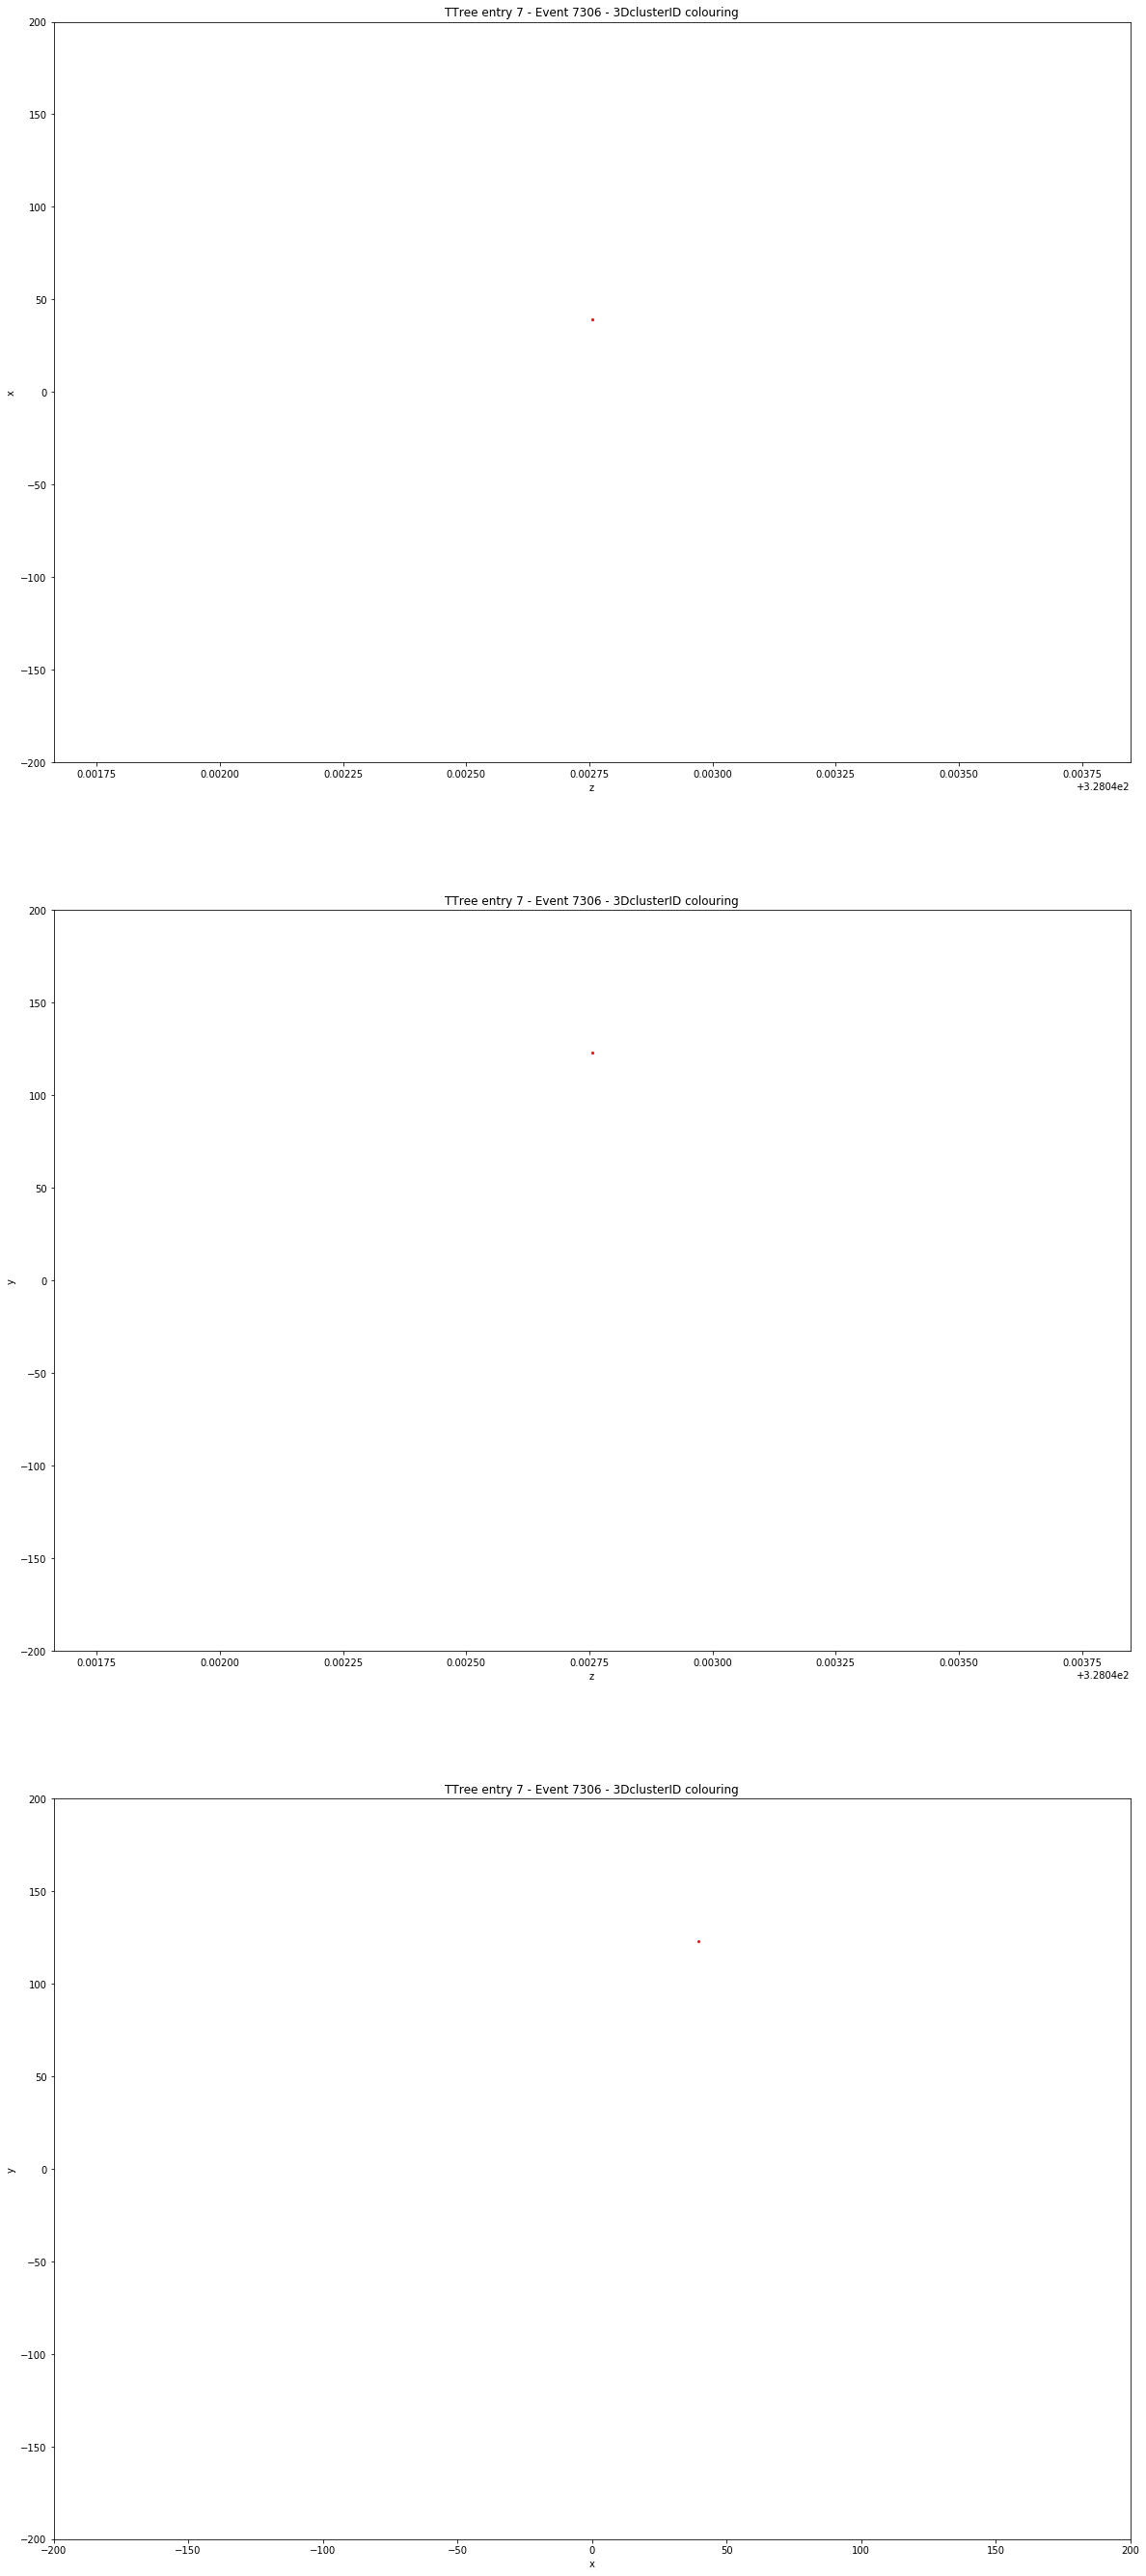

In [44]:
fig = plt.figure(figsize = (20,48))
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)
ax4 = fig.add_subplot(313)

cmap = 'Set1'

c = clusterID
s = np.sqrt(energy)*10

m_style = 'o'
ax2.scatter(z, x, c = c, s = s, marker = m_style, cmap = cmap)
ax3.scatter(z, y, c = c, s = s, marker = m_style, cmap = cmap)    
m_style = 'H'
ax4.scatter(x, y, c = c, s = s, marker = m_style, cmap = cmap)


for i in gen_dict:
    gen_x = gen_dict[i]['v4'].Px()
    gen_y = gen_dict[i]['v4'].Py()
    gen_z = gen_dict[i]['v4'].Pz()
    gen_e = gen_dict[i]['v4'].E()
    gen_eta_sig = np.sign(gen_dict[i]['v4'].Eta())
    gen_dm = gen_dict[i]['DM']
    up_scale = 500/gen_z
    down_scale = 320/gen_z
    if gen_dm == 0: gen_c = 'limegreen'; lab=' 1-prong'
    elif gen_dm == 1: gen_c = 'blue'; lab=' 1-prong + \pi^0'
    elif gen_dm == 10: gen_c = 'orange'; lab=' 3-prong'
    elif gen_dm == 11: gen_c = 'fuchsia'; lab=' 3-prong + \pi^0'
    elif gen_dm == -2: gen_c = 'cyan'; lab='QCD'
    if side*gen_eta_sig > 0: 
        
        ax2.plot([gen_z*gen_eta_sig*down_scale,gen_z*gen_eta_sig*up_scale],[gen_x,gen_x*2], c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)
        ax3.plot([gen_z*gen_eta_sig*down_scale,gen_z*gen_eta_sig*up_scale],[gen_y,gen_y*2], c = gen_c) #, label = r"$\tau_{gen}: %s"%lab)
        ax4.scatter([gen_x],[gen_y], marker='*', c = gen_c, s=gen_e) #, label = r"$\tau_{gen}: %s$"%lab)

#if side < 0: plt.legend(loc = 'upper left', fontsize=15)
#else: plt.legend(loc = 'upper right', fontsize=15)
    
    
ax2.set_xlabel('z'); ax2.set_ylabel('x')
ax2.set_ylim(-200,200); ax4.set_xlim(-200,200)
ax3.set_xlabel('z'); ax3.set_ylabel('y')
ax3.set_ylim(-200,200); ax4.set_xlim(-200,200)
ax4.set_xlabel('x'); ax4.set_ylabel('y')
ax4.set_ylim(-200,200); ax4.set_xlim(-200,200)

#fig.suptitle('Event %i' % event)#, fontsize=16)
ax2.set_title('TTree entry %i - Event %i - 3DclusterID colouring' % (entry, event))
ax3.set_title('TTree entry %i - Event %i - 3DclusterID colouring' % (entry, event))
ax4.set_title('TTree entry %i - Event %i - 3DclusterID colouring' % (entry, event))

fig.show()

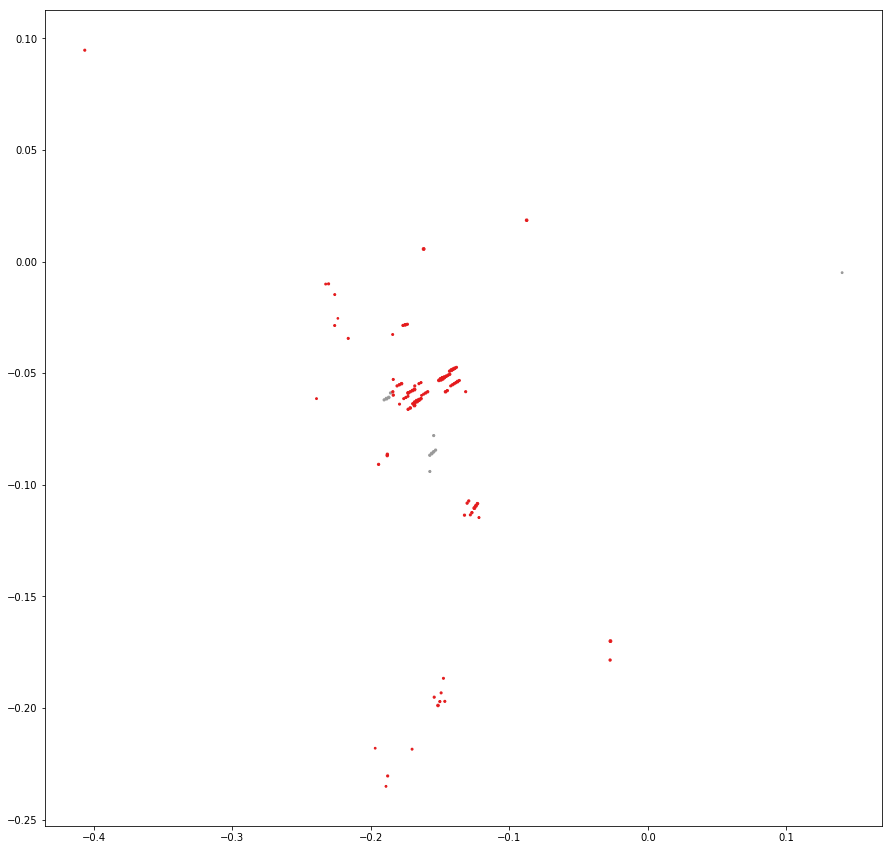

In [23]:
fig = plt.figure(figsize = (15,15))
ax4 = fig.add_subplot(111)

cmap = 'Set1'

c = clusterID
s = np.sqrt(energy)*10

m_style = 'H'
ax4.scatter(ROOT.vectorRatio(x,z), ROOT.vectorRatio(y,z), c = c, s = s, marker = m_style, cmap = cmap)

# ------------------------------------------------------
# ------------------------------------------------------

## TEST STUFF THAT IS NOT WORKING

In [ ]:
ROOT.ROOT.EnableImplicitMT(1)
df = ROOT.RDataFrame("SkimmedTree", indir+'/SKIM_RelValTenTau_PU200/mergedOutput.root')

In [ ]:
df_z = df.Filter("tc_zside > 0")
report = df_z.Report()
report.Print()

In [ ]:
print(len(clusterID))

In [ ]:
ROOT.gInterpreter.Declare('''
vector< vector<float> > zSideSelection(string file_name, string tree_name, int entry) {
    cout << "here 1" << endl;
    TFile rfile(file_name.c_str());
    TTree * tree = (TTree *)rfile.Get(tree_name.c_str());
    cout << "here 2" << endl;
    vector< vector<float> > out;
    vector<float> out_tc_x;
    vector<float> out_tc_y;
    vector<float> out_tc_z;
    vector<float> out_tc_layer;
    vector<float> out_tc_cluster_id;
    vector<float> out_tc_energy;
    cout << "here 3" << endl;
    vector<float> *in_tc_x;
    vector<float> *in_tc_y;
    vector<float> *in_tc_z;
    vector<float> *in_tc_layer;
    vector<float> *in_tc_cluster_id;
    vector<float> *in_tc_energy;
    vector<float> *in_tc_zside;
    cout << "here 4" << endl;
    tree->SetBranchAddress("tc_x", &in_tc_x);
    tree->SetBranchAddress("tc_y", &in_tc_y);
    tree->SetBranchAddress("tc_z", &in_tc_z);
    tree->SetBranchAddress("tc_layer", &in_tc_layer);
    tree->SetBranchAddress("tc_cluster_id", &in_tc_cluster_id);
    tree->SetBranchAddress("tc_energy", &in_tc_energy);
    tree->SetBranchAddress("tc_zside", &in_tc_zside);
    
    cout << "here 5" << endl;
    int entry_ok = tree->GetEntry((Long64_t)entry);
    cout << "here 6" << endl;
    if(entry_ok<0) {
        cout << "ENTRY " << entry << " NOT FOUND. MAX NUMBER OF ENTRIES IS " << tree->GetEntries() << endl;
        return out;
    }

    int tcs = (*in_tc_zside).size();

    cout << (*in_tc_zside).size() << endl;

    for (int i=0; i<tcs; i++){
        if ((*in_tc_zside)[i] < 0) continue;
        out_tc_x.push_back((*in_tc_x)[i]);
        out_tc_y.push_back((*in_tc_y)[i]);
        out_tc_z.push_back((*in_tc_z)[i]);
        out_tc_layer.push_back((*in_tc_layer)[i]);
        out_tc_cluster_id.push_back((*in_tc_cluster_id)[i]);
        out_tc_energy.push_back((*in_tc_energy)[i]);
    }

    out.push_back(out_tc_x);
    out.push_back(out_tc_y);
    out.push_back(out_tc_z);
    out.push_back(out_tc_layer);
    out.push_back(out_tc_cluster_id);
    out.push_back(out_tc_energy);
    
    return out;    
}
''')

indir = '/data_CMS_upgrade/motta/HGCAL_SKIMS/SKIM_18Feb2021'
rfile = indir+'/SKIM_GluGluHHTo2b2Tau_PU200/mergedOutput.root'
tree = 'SkimmedTree'
entry = 1000

xyzlie_vector = ROOT.zSideSelection(rfile, tree, entry)
print(len(xyzlie_vector))